In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import pyCompare 
import matplotlib
import keras_tuner as kt

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from yellowbrick.regressor import PredictionError, ResidualsPlot
from matplotlib import pyplot as plt
%matplotlib inline
np.random.seed(42)
tf.random.set_seed(42)
from collections import Counter
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras_tuner.tuners import BayesianOptimization, Hyperband
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
sns.set(rc = {'figure.figsize': (10,6)})
sns.set(style="whitegrid",font_scale = 2 )

### Import, wrangle, and preprocess data

In [3]:
data = pd.read_csv('./Data/AGP_MMCNN_BSsurvey_pollock2014to2018.csv')
print(data.shape)
data.head(2)

(8629, 915)


,file_name,sample,Age,latitude,length,gear_depth,gear_temp,wn11476.85064,wn11468.60577,wn11460.36091,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
0,WALLEYE_POLLOCK_157201603201_60411_OT1.0,training,10.0,53.97653,610.0,407.26,4.33,0.313066,0.313311,0.313633,...,1.316385,1.328887,1.339621,1.349055,1.357497,1.365173,1.372687,1.380318,1.387681,1.394300
1,WALLEYE_POLLOCK_157201603201_60412_OT1.0,training,9.0,53.97653,611.0,407.26,4.33,0.329684,0.330087,0.330593,...,1.314472,1.330901,1.345002,1.357586,1.369454,1.380857,1.391871,1.402634,1.413231,1.423495


In [4]:
# exclude outliers 
data.drop(data[data['sample'] == 'outlier'].index, inplace = True)
data.shape

(8617, 915)

In [5]:
data.rename(columns={"final_age":"Age"}, inplace=True) # rename column
data.isnull().values.any() # check if NaNs 

False

In [6]:
X_train = data[data['sample'] == 'training'] 
X_test = data[data['sample'] == 'test']
print(X_train.shape)
print(X_test.shape)

(6866, 915)
(1751, 915)


In [7]:
y_train=X_train.pop('Age')
y_test=X_test.pop('Age')
f_train=X_train.pop('file_name')
f_test=X_test.pop('file_name')
s_train=X_train.pop('sample')
s_test=X_test.pop('sample')

In [8]:
X_train_A=X_train[X_train.columns[0:4]]
X_train_A.head(2)

,latitude,length,gear_depth,gear_temp
0,53.97653,610.0,407.26,4.33
1,53.97653,611.0,407.26,4.33


In [9]:
X_test_A=X_test[X_test.columns[0:4]]
X_test_A.head(2)

,latitude,length,gear_depth,gear_temp
6866,53.82690,475.0,337.91,4.38
6867,53.60675,432.0,420.46,4.16


In [10]:
X_train_B=X_train[X_train.columns[4:]]
X_train_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
0,0.313066,0.313311,0.313633,0.314050,0.314400,0.314564,0.314640,0.314813,0.315161,0.315461,...,1.316385,1.328887,1.339621,1.349055,1.357497,1.365173,1.372687,1.380318,1.387681,1.394300
1,0.329684,0.330087,0.330593,0.330941,0.331056,0.331168,0.331501,0.332027,0.332488,0.332693,...,1.314472,1.330901,1.345002,1.357586,1.369454,1.380857,1.391871,1.402634,1.413231,1.423495


In [11]:
X_test_B=X_test[X_test.columns[4:]]
X_test_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
6866,0.349371,0.349258,0.349383,0.34944,0.349547,0.349898,0.350280,0.350478,0.350528,0.350582,...,1.169712,1.183594,1.195676,1.206412,1.216414,1.226195,1.235933,1.245539,1.254753,1.263192
6867,0.330212,0.330414,0.330697,0.33127,0.331903,0.332098,0.331886,0.331744,0.331770,0.331900,...,1.161812,1.176941,1.190388,1.202517,1.213842,1.224860,1.236009,1.247214,1.258091,1.268352


In [12]:
# preprocess spectra
preprTR = savgol_filter(X_train_B.values[:,:], 17, polyorder = 2,deriv=1) 
preprTE = savgol_filter(X_test_B.values[:,:], 17, polyorder = 2,deriv=1) 

In [13]:
X_train_B = pd.DataFrame(preprTR, index=X_train_B.index, columns=X_train_B.columns)
X_train_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
0,0.000357,0.000337,0.000317,0.000296,0.000276,0.000256,0.000236,0.000216,0.000195,0.000183,...,0.012600,0.011908,0.011003,0.010099,0.009194,0.008290,0.007385,0.006481,0.005576,0.004672
1,0.000323,0.000316,0.000308,0.000301,0.000293,0.000285,0.000278,0.000270,0.000263,0.000251,...,0.016221,0.015551,0.014613,0.013676,0.012738,0.011801,0.010863,0.009926,0.008988,0.008051


In [14]:
X_test_B = pd.DataFrame(preprTE, index=X_test_B.index, columns=X_test_B.columns)
X_test_B.head(2)

,wn11476.85064,wn11468.60577,wn11460.36091,wn11452.11604,wn11443.87118,wn11435.62632,wn11427.38145,wn11419.13659,wn11410.89172,wn11402.64686,...,wn4072.962798,wn4064.717934,wn4056.47307,wn4048.228206,wn4039.983342,wn4031.738478,wn4023.493614,wn4015.24875,wn4007.003886,wn3998.759022
6866,0.00013,0.000139,0.000147,0.000155,0.000164,0.000172,0.000180,0.000188,0.000197,0.000204,...,0.013741,0.013202,0.012445,0.011688,0.010931,0.010174,0.009417,0.008660,0.007903,0.007146
6867,0.00021,0.000215,0.000219,0.000224,0.000228,0.000233,0.000238,0.000242,0.000247,0.000245,...,0.014838,0.014391,0.013711,0.013030,0.012350,0.011670,0.010990,0.010309,0.009629,0.008949


Apply standard scaling (zero mean, unit deviation) to input variables

In [15]:
scaler_y=StandardScaler()
scaler_y.fit(y_train.values.reshape(-1,1))
y_train=scaler_y.transform(y_train.values.reshape(-1,1))
y_test=scaler_y.transform(y_test.values.reshape(-1,1))

In [16]:
scaler_x=StandardScaler()
scaler_x.fit(X_train_A)
X_train_A=pd.DataFrame(scaler_x.transform(X_train_A), columns=X_train_A.columns)
X_test_A=pd.DataFrame(scaler_x.transform(X_test_A), columns=X_test_A.columns)
X_train_A.head()

,latitude,length,gear_depth,gear_temp
0,-2.428245,1.312891,7.20376,0.596944
1,-2.428245,1.319904,7.20376,0.596944
2,-2.428245,0.141645,7.20376,0.596944
3,-2.428245,0.394129,7.20376,0.596944
4,-2.428245,0.197752,7.20376,0.596944


### Build and train MMCNN model

Build a model with support for hyperparameter tuning via keras tuner library

In [17]:
input_dim_A=X_train_A.shape[1]
input_dim_A

4

In [18]:
input_dim_B=X_train_B.shape[1]
input_dim_B

908

In [19]:
def build_model(hp): 
    input_A = Input(shape=(input_dim_A, ))
    x = input_A

    input_B = Input(shape=(input_dim_B,1))
    y = Conv1D(
        hp.Int('num_filters', 50, 100, step=10, default=50), 
        kernel_size=201, strides=101, activation='relu', padding='same')(input_B)
    y = Flatten()(y)
    y = Dense(4, activation="relu", name='output_B')(y)

    con = concatenate(inputs = [x,y] ) # merge

    z=Dense(
        hp.Int('dense', 4, 640, step=32, default=256), 
        activation='relu',
        )(con)
    z=Dropout(hp.Float('dropout-2', 0.0, 0.5, step=0.05, default=0.0))(z)
    
    output = Dense(1, activation="linear")(z)
    model = Model(inputs=[input_A, input_B], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return model    

In [20]:
# instantiate the tuner
# the objective is to minimize valuation loss, which in this case is mean squared error
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=200,
    directory='Tuners',
    project_name='mmcnn',
    seed=42
)

INFO:tensorflow:Reloading Oracle from existing project Tuners\mmcnn\oracle.json
INFO:tensorflow:Reloading Tuner from Tuners\mmcnn\tuner0.json


In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_filters (Int)
{'default': 50, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 10, 'sampling': None}
dense (Int)
{'default': 256, 'conditions': [], 'min_value': 4, 'max_value': 640, 'step': 32, 'sampling': None}
dropout-2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}


In [22]:
# set up checkpoints, then start training and optimization
nb_epoch = 200
batch_size = 32
outputFilePath='Estimator'
checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=7,
                         verbose=1,
                         restore_best_weights=True
                         )

In [23]:
tuner.search([X_train_A, X_train_B], y_train,
            epochs=nb_epoch,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.25, 
            verbose=1,
            callbacks=[earlystop]
            )

INFO:tensorflow:Oracle triggered exit


In [24]:
model = tuner.get_best_models(num_models=1)[0]

In [25]:
best_hp = tuner.get_best_hyperparameters()[0]

In [26]:
best_hp.values

{'num_filters': 100,
 'dense': 196,
 'dropout-2': 0.30000000000000004,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0206'}

In [27]:
# one more training pass
nb_epoch = 2000
batch_size = 32

outputFilePath = 'Estimator'

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=100,
                         verbose=1,
                         restore_best_weights=True
                         )

In [28]:
history = model.fit([X_train_A, X_train_B], y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.25,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Epoch 1/2000
161/161 [==============================] - 1s 2ms/step - loss: 0.1135 - mse: 0.1135 - mae: 0.2412 - val_loss: 0.1187 - val_mse: 0.1187 - val_mae: 0.2559

Epoch 00001: val_loss improved from inf to 0.11868, saving model to Estimator
INFO:tensorflow:Assets written to: Estimator\assets
Epoch 2/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.1143 - mse: 0.1143 - mae: 0.2408 - val_loss: 0.1270 - val_mse: 0.1270 - val_mae: 0.2685

Epoch 00002: val_loss did not improve from 0.11868
Epoch 3/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.1119 - mse: 0.1119 - mae: 0.2411 - val_loss: 0.1385 - val_mse: 0.1385 - val_mae: 0.2652

Epoch 00003: val_loss did not improve from 0.11868
Epoch 4/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.1144 - mse: 0.1144 - mae: 0.2419 - val_loss: 0.1238 - val_mse: 0.1238 - val_mae: 0.2567

Epoch 00004: val_loss did not improve from 0.11868
Epoch 5/2000
161/161 [===========================

161/161 [==============================] - 0s 1ms/step - loss: 0.1032 - mse: 0.1032 - mae: 0.2327 - val_loss: 0.1203 - val_mse: 0.1203 - val_mae: 0.2502

Epoch 00036: val_loss did not improve from 0.10802
Epoch 37/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.1002 - mse: 0.1002 - mae: 0.2308 - val_loss: 0.1060 - val_mse: 0.1060 - val_mae: 0.2397

Epoch 00037: val_loss improved from 0.10802 to 0.10597, saving model to Estimator
INFO:tensorflow:Assets written to: Estimator\assets
Epoch 38/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.1020 - mse: 0.1020 - mae: 0.2304 - val_loss: 0.1070 - val_mse: 0.1070 - val_mae: 0.2430

Epoch 00038: val_loss did not improve from 0.10597
Epoch 39/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.1017 - mse: 0.1017 - mae: 0.2311 - val_loss: 0.1101 - val_mse: 0.1101 - val_mae: 0.2427

Epoch 00039: val_loss did not improve from 0.10597
Epoch 40/2000
161/161 [==============================] 


Epoch 00069: val_loss did not improve from 0.09559
Epoch 70/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0921 - mse: 0.0921 - mae: 0.2207 - val_loss: 0.0962 - val_mse: 0.0962 - val_mae: 0.2335

Epoch 00070: val_loss did not improve from 0.09559
Epoch 71/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0901 - mse: 0.0901 - mae: 0.2209 - val_loss: 0.1026 - val_mse: 0.1026 - val_mae: 0.2345

Epoch 00071: val_loss did not improve from 0.09559
Epoch 72/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0914 - mse: 0.0914 - mae: 0.2205 - val_loss: 0.0984 - val_mse: 0.0984 - val_mae: 0.2316

Epoch 00072: val_loss did not improve from 0.09559
Epoch 73/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0932 - mse: 0.0932 - mae: 0.2230 - val_loss: 0.1060 - val_mse: 0.1060 - val_mae: 0.2363

Epoch 00073: val_loss did not improve from 0.09559
Epoch 74/2000
161/161 [==============================] - 0s 1ms/step - l

161/161 [==============================] - 0s 1ms/step - loss: 0.0864 - mse: 0.0864 - mae: 0.2154 - val_loss: 0.0915 - val_mse: 0.0915 - val_mae: 0.2259

Epoch 00106: val_loss did not improve from 0.09098
Epoch 107/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0883 - mse: 0.0883 - mae: 0.2172 - val_loss: 0.1025 - val_mse: 0.1025 - val_mae: 0.2399

Epoch 00107: val_loss did not improve from 0.09098
Epoch 108/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0883 - mse: 0.0883 - mae: 0.2177 - val_loss: 0.0965 - val_mse: 0.0965 - val_mae: 0.2331

Epoch 00108: val_loss did not improve from 0.09098
Epoch 109/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0884 - mse: 0.0884 - mae: 0.2181 - val_loss: 0.0924 - val_mse: 0.0924 - val_mae: 0.2272

Epoch 00109: val_loss did not improve from 0.09098
Epoch 110/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0874 - mse: 0.0874 - mae: 0.2183 - val_loss: 0.1258 - v


Epoch 00142: val_loss did not improve from 0.08793
Epoch 143/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0853 - mse: 0.0853 - mae: 0.2148 - val_loss: 0.0892 - val_mse: 0.0892 - val_mae: 0.2224

Epoch 00143: val_loss did not improve from 0.08793
Epoch 144/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0869 - mse: 0.0869 - mae: 0.2155 - val_loss: 0.0913 - val_mse: 0.0913 - val_mae: 0.2214

Epoch 00144: val_loss did not improve from 0.08793
Epoch 145/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0859 - mse: 0.0859 - mae: 0.2154 - val_loss: 0.1055 - val_mse: 0.1055 - val_mae: 0.2332

Epoch 00145: val_loss did not improve from 0.08793
Epoch 146/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0884 - mse: 0.0884 - mae: 0.2161 - val_loss: 0.0985 - val_mse: 0.0985 - val_mae: 0.2303

Epoch 00146: val_loss did not improve from 0.08793
Epoch 147/2000
161/161 [==============================] - 0s 1ms/ste

161/161 [==============================] - 0s 1ms/step - loss: 0.0837 - mse: 0.0837 - mae: 0.2128 - val_loss: 0.0978 - val_mse: 0.0978 - val_mae: 0.2261

Epoch 00180: val_loss did not improve from 0.08793
Epoch 181/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2147 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2169

Epoch 00181: val_loss improved from 0.08793 to 0.08690, saving model to Estimator
INFO:tensorflow:Assets written to: Estimator\assets
Epoch 182/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0835 - mse: 0.0835 - mae: 0.2111 - val_loss: 0.0904 - val_mse: 0.0904 - val_mae: 0.2188

Epoch 00182: val_loss did not improve from 0.08690
Epoch 183/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0847 - mse: 0.0847 - mae: 0.2135 - val_loss: 0.0928 - val_mse: 0.0928 - val_mae: 0.2298

Epoch 00183: val_loss did not improve from 0.08690
Epoch 184/2000
161/161 [============================


Epoch 00216: val_loss did not improve from 0.08601
Epoch 217/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2122 - val_loss: 0.1089 - val_mse: 0.1089 - val_mae: 0.2528

Epoch 00217: val_loss did not improve from 0.08601
Epoch 218/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0863 - mse: 0.0863 - mae: 0.2153 - val_loss: 0.1091 - val_mse: 0.1091 - val_mae: 0.2350

Epoch 00218: val_loss did not improve from 0.08601
Epoch 219/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0826 - mse: 0.0826 - mae: 0.2115 - val_loss: 0.0891 - val_mse: 0.0891 - val_mae: 0.2185

Epoch 00219: val_loss did not improve from 0.08601
Epoch 220/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0853 - mse: 0.0853 - mae: 0.2128 - val_loss: 0.0958 - val_mse: 0.0958 - val_mae: 0.2247

Epoch 00220: val_loss did not improve from 0.08601
Epoch 221/2000
161/161 [==============================] - 0s 1ms/ste

161/161 [==============================] - 0s 1ms/step - loss: 0.0859 - mse: 0.0859 - mae: 0.2155 - val_loss: 0.1171 - val_mse: 0.1171 - val_mae: 0.2486

Epoch 00254: val_loss did not improve from 0.08601
Epoch 255/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0834 - mse: 0.0834 - mae: 0.2122 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2153

Epoch 00255: val_loss did not improve from 0.08601
Epoch 256/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0826 - mse: 0.0826 - mae: 0.2117 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2207

Epoch 00256: val_loss did not improve from 0.08601
Epoch 257/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0821 - mse: 0.0821 - mae: 0.2087 - val_loss: 0.0877 - val_mse: 0.0877 - val_mae: 0.2139

Epoch 00257: val_loss did not improve from 0.08601
Epoch 258/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.2086 - val_loss: 0.0976 - v

161/161 [==============================] - 0s 1ms/step - loss: 0.0836 - mse: 0.0836 - mae: 0.2128 - val_loss: 0.1120 - val_mse: 0.1120 - val_mae: 0.2383

Epoch 00291: val_loss did not improve from 0.08478
Epoch 292/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0808 - mse: 0.0808 - mae: 0.2102 - val_loss: 0.0940 - val_mse: 0.0940 - val_mae: 0.2196

Epoch 00292: val_loss did not improve from 0.08478
Epoch 293/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0828 - mse: 0.0828 - mae: 0.2118 - val_loss: 0.0883 - val_mse: 0.0883 - val_mae: 0.2193

Epoch 00293: val_loss did not improve from 0.08478
Epoch 294/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0808 - mse: 0.0808 - mae: 0.2096 - val_loss: 0.0856 - val_mse: 0.0856 - val_mae: 0.2146

Epoch 00294: val_loss did not improve from 0.08478
Epoch 295/2000
161/161 [==============================] - 0s 2ms/step - loss: 0.0841 - mse: 0.0841 - mae: 0.2134 - val_loss: 0.0874 - v

161/161 [==============================] - 0s 1ms/step - loss: 0.0780 - mse: 0.0780 - mae: 0.2068 - val_loss: 0.0859 - val_mse: 0.0859 - val_mae: 0.2144

Epoch 00328: val_loss did not improve from 0.08478
Epoch 329/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0806 - mse: 0.0806 - mae: 0.2094 - val_loss: 0.0862 - val_mse: 0.0862 - val_mae: 0.2158

Epoch 00329: val_loss did not improve from 0.08478
Epoch 330/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0833 - mse: 0.0833 - mae: 0.2135 - val_loss: 0.0977 - val_mse: 0.0977 - val_mae: 0.2256

Epoch 00330: val_loss did not improve from 0.08478
Epoch 331/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0809 - mse: 0.0809 - mae: 0.2093 - val_loss: 0.0989 - val_mse: 0.0989 - val_mae: 0.2282

Epoch 00331: val_loss did not improve from 0.08478
Epoch 332/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0823 - mse: 0.0823 - mae: 0.2109 - val_loss: 0.1003 - v

161/161 [==============================] - 0s 1ms/step - loss: 0.0790 - mse: 0.0790 - mae: 0.2076 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.2177

Epoch 00364: val_loss did not improve from 0.08395
Epoch 365/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0803 - mse: 0.0803 - mae: 0.2089 - val_loss: 0.0947 - val_mse: 0.0947 - val_mae: 0.2213

Epoch 00365: val_loss did not improve from 0.08395
Epoch 366/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0802 - mse: 0.0802 - mae: 0.2085 - val_loss: 0.0880 - val_mse: 0.0880 - val_mae: 0.2182

Epoch 00366: val_loss did not improve from 0.08395
Epoch 367/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0813 - mse: 0.0813 - mae: 0.2095 - val_loss: 0.0878 - val_mse: 0.0878 - val_mae: 0.2188

Epoch 00367: val_loss did not improve from 0.08395
Epoch 368/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0806 - mse: 0.0806 - mae: 0.2089 - val_loss: 0.1045 - v

161/161 [==============================] - 0s 1ms/step - loss: 0.0807 - mse: 0.0807 - mae: 0.2086 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2144

Epoch 00401: val_loss did not improve from 0.08395
Epoch 402/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0803 - mse: 0.0803 - mae: 0.2084 - val_loss: 0.1004 - val_mse: 0.1004 - val_mae: 0.2265

Epoch 00402: val_loss did not improve from 0.08395
Epoch 403/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0799 - mse: 0.0799 - mae: 0.2075 - val_loss: 0.0948 - val_mse: 0.0948 - val_mae: 0.2229

Epoch 00403: val_loss did not improve from 0.08395
Epoch 404/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0834 - mse: 0.0834 - mae: 0.2123 - val_loss: 0.0989 - val_mse: 0.0989 - val_mae: 0.2303

Epoch 00404: val_loss did not improve from 0.08395
Epoch 405/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0791 - mse: 0.0791 - mae: 0.2088 - val_loss: 0.0846 - v

161/161 [==============================] - 0s 1ms/step - loss: 0.0797 - mse: 0.0797 - mae: 0.2072 - val_loss: 0.0926 - val_mse: 0.0926 - val_mae: 0.2192

Epoch 00438: val_loss did not improve from 0.08395
Epoch 439/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0818 - mse: 0.0818 - mae: 0.2088 - val_loss: 0.0861 - val_mse: 0.0861 - val_mae: 0.2181

Epoch 00439: val_loss did not improve from 0.08395
Epoch 440/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0781 - mse: 0.0781 - mae: 0.2067 - val_loss: 0.0931 - val_mse: 0.0931 - val_mae: 0.2188

Epoch 00440: val_loss did not improve from 0.08395
Epoch 441/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0797 - mse: 0.0797 - mae: 0.2088 - val_loss: 0.0931 - val_mse: 0.0931 - val_mae: 0.2198

Epoch 00441: val_loss did not improve from 0.08395
Epoch 442/2000
161/161 [==============================] - 0s 1ms/step - loss: 0.0817 - mse: 0.0817 - mae: 0.2114 - val_loss: 0.0863 - v

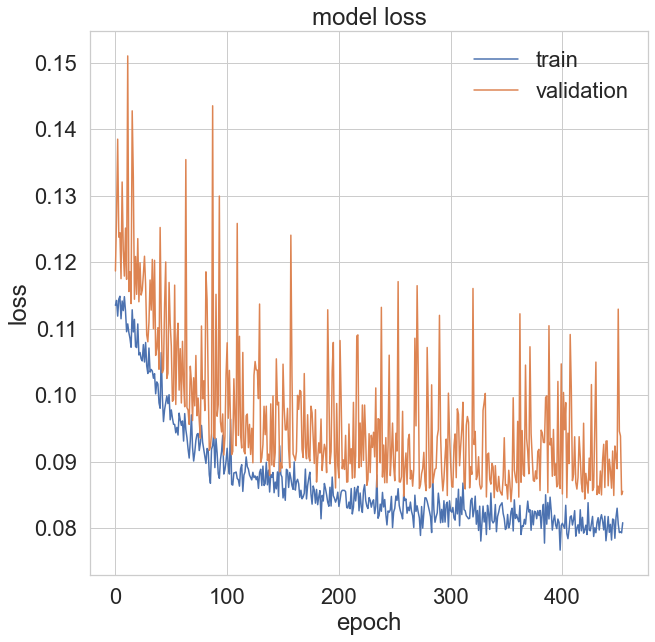

In [29]:
plt.figure(figsize=(10,10))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

Evaluate model and compute R2 score

In [30]:
model.evaluate([X_test_A,X_test_B], y_test)

55/55 [==============================] - 0s 513us/step - loss: 0.0907 - mse: 0.0907 - mae: 0.2122


[0.09073647856712341, 0.09073647856712341, 0.21224336326122284]

In [31]:
preds=model.predict([X_test_A,X_test_B])

In [32]:
#from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.9155557244868588

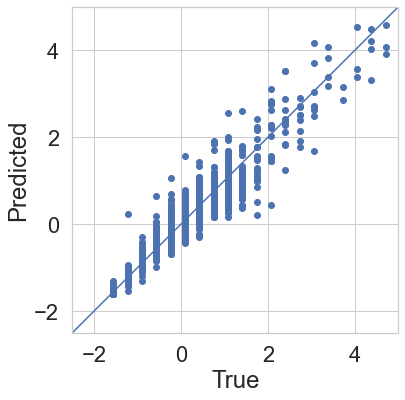

In [33]:
plt.figure(figsize=(6,6))
a = plt.axes(aspect='equal')
plt.scatter(y_test, preds)
plt.xlabel('True')
plt.ylabel('Predicted')
lims = [-2.5, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Error distribution

In [34]:
preds=preds.flatten()

In [35]:
y_test=y_test.flatten()

In [36]:
error = preds - y_test

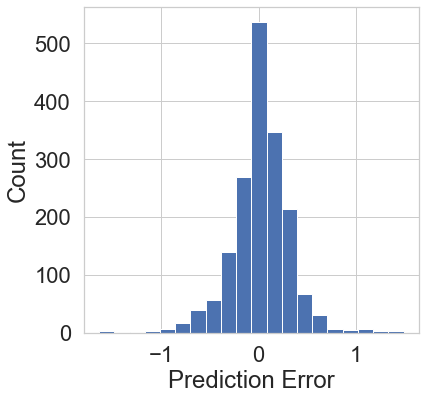

In [37]:
plt.figure(figsize=(6,6))
plt.hist(error, bins=20)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 908, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 9, 100)       20200       input_2[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 900)          0           conv1d[0][0]                     
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4)]          0                                            
______________________________________________________________________________________________

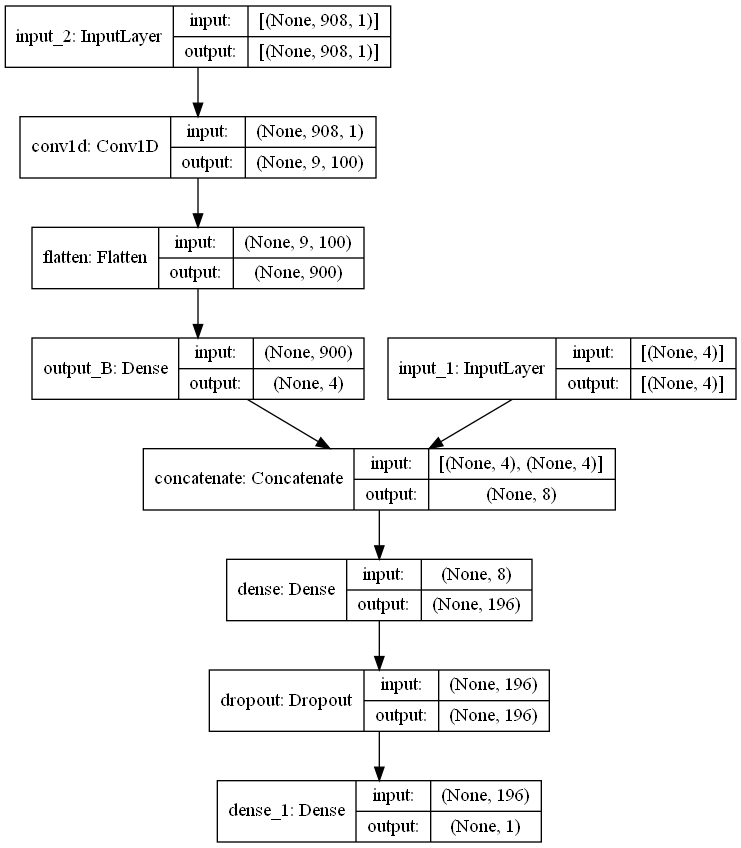

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Training data

In [40]:
# training set
preds_t=model.predict([X_train_A,X_train_B])
r2_score(y_train, preds_t)

0.9254122256565596

In [41]:
#undo normalization 
y_pr_transformed=scaler_y.inverse_transform(preds_t)
len(y_pr_transformed)

6866

In [42]:
y_tr_transformed=scaler_y.inverse_transform(y_train.reshape(-1, 1))
len(y_tr_transformed)

6866

In [43]:
r_squared_tr=r2_score(y_tr_transformed,y_pr_transformed)
round(r_squared_tr,2)

0.93

In [44]:
rmse_tr = sqrt(mean_squared_error(y_tr_transformed, y_pr_transformed))
round(rmse_tr,2)

0.83

In [45]:
#need to join y_tr_transformed, y_pr_transformed, f_train 
y_tr_df = pd.DataFrame(y_tr_transformed)
y_tr_df.columns =['train']
y_tr_df['pred']=y_pr_transformed
f_train_reset=f_train.reset_index()
del f_train_reset['index']
y_tr_df['file']=f_train_reset
y_tr_df.head(2)

,train,pred,file
0,10.0,10.157588,WALLEYE_POLLOCK_157201603201_60411_OT1.0
1,9.0,8.171957,WALLEYE_POLLOCK_157201603201_60412_OT1.0


In [46]:
y_tr_df.to_csv('./Output/Data/train_predictions.csv')

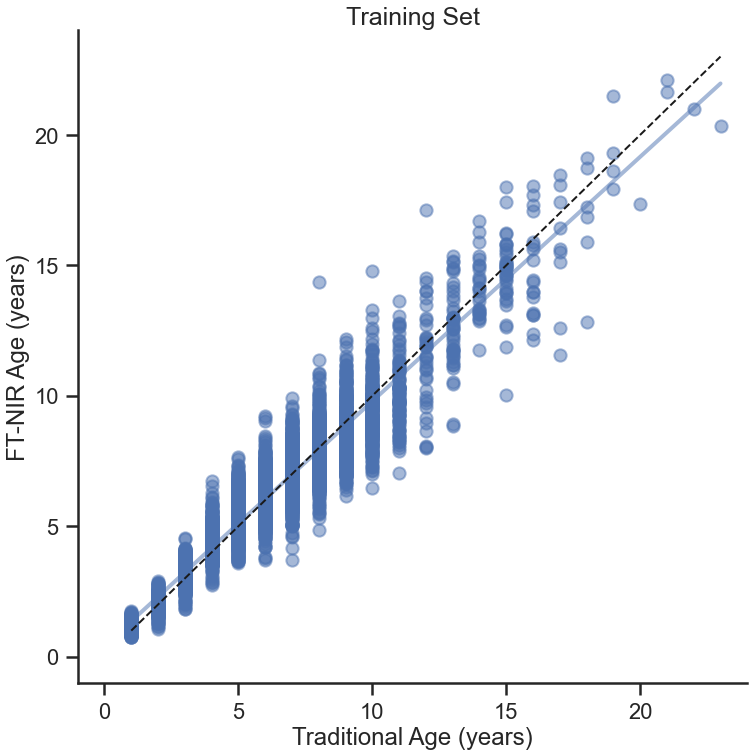

In [47]:
sns.set_style("white")
sns.set(style="ticks")
sns.set_context("poster")

f, ax = plt.subplots(figsize=(12, 12))
p=sns.regplot(x=y_tr_transformed, y=y_pr_transformed, ci=None, scatter_kws={"edgecolor": 'b','linewidth':2,"alpha": 0.5, "s": 150}, line_kws = {"alpha": 0.5, "lw":4})
ax.plot([y_tr_transformed.min(), y_tr_transformed.max()], [y_tr_transformed.min(), y_tr_transformed.max()], 'k--', lw=2)

# control x and y limits
p.set(xlim=(-1, 24))
p.set(ylim=(-1, 24))
sns.despine()
plt.title('Training Set', fontsize = 25)
plt.xlabel('Traditional Age (years)')
plt.ylabel('FT-NIR Age (years)')
plt.savefig('./Output/Figures/TrainingSet.png')

#### Test data

In [48]:
#undo normalization 
y_pred_transformed=scaler_y.inverse_transform(preds.reshape(-1, 1))
y_test_transformed=scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [49]:
r_squared=r2_score(y_test_transformed,y_pred_transformed)
round(r_squared,2)

0.92

In [50]:
rmse = sqrt(mean_squared_error(y_test_transformed, y_pred_transformed))
round(rmse,2)

0.91

In [55]:
#need to join y_test_transformed, y_pred_transformed, f_test=X_test.pop('file_name') 
y_test_df = pd.DataFrame(y_test_transformed)
y_test_df.columns =['test']
y_test_df['pred']=y_pred_transformed
f_test_reset=f_test.reset_index()
del f_test_reset['index']
y_test_df['file']=f_test_reset
y_test_df.head(2)

,test,pred,file
0,8.0,6.831635,WALLEYE_POLLOCK_157201603201_60482_OT1.0
1,7.0,4.975235,WALLEYE_POLLOCK_157201603201_60560_OT1.0


In [52]:
y_test_df.to_csv('./Output/Data/test_predictions.csv')

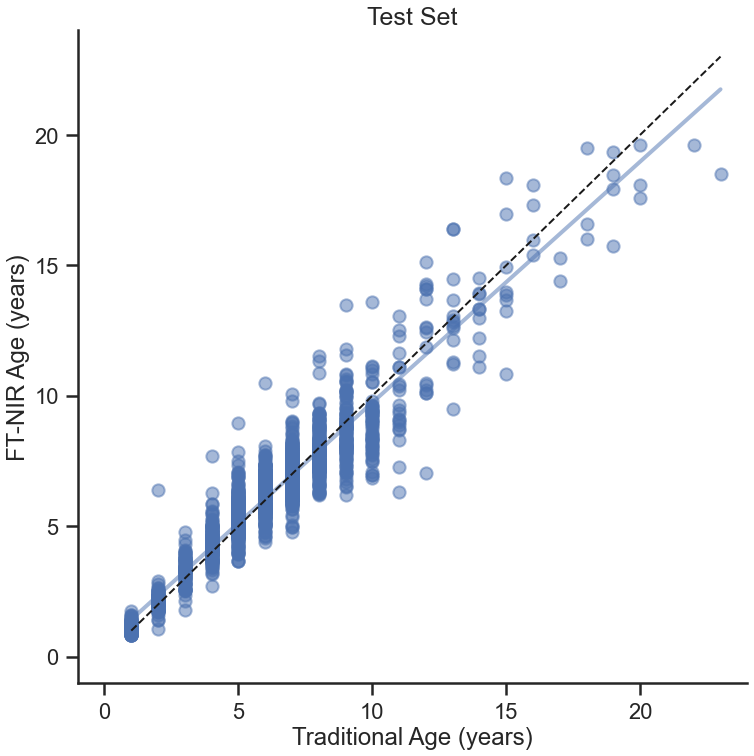

In [53]:
f, ax = plt.subplots(figsize=(12, 12))
p=sns.regplot(x=y_test_transformed, y=y_pred_transformed, ci=None, scatter_kws={"edgecolor": 'b','linewidth':2,"alpha": 0.5, "s": 150}, line_kws = {"alpha": 0.5, "lw":4})
ax.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)

# control x and y limits
p.set(xlim=(-1, 24))
p.set(ylim=(-1, 24))
sns.despine()
plt.title('Test Set', fontsize = 25)
plt.xlabel('Traditional Age (years)')
plt.ylabel('FT-NIR Age (years)')
plt.savefig('./Output/Figures/TestSet.png')

In [54]:
pyCompare.blandAltman(y_test_transformed.flatten(), y_pred_transformed.flatten(), #used flatten() to change to 1d array
                      limitOfAgreement=1.96, confidenceInterval=95,
                      confidenceIntervalMethod='approximate',
                      detrend=None, percentage=False,
                      title='Bland-Altman Plot\n',
                      savePath='./Output/Figures/BlandAltman.png'
                      )